# Introducción
En este notebook continuaremos y replicaremos el desarrollo realizado en el anterior pero con otros entornos. En este caso, modificaremos usaremos el entorno LTS y lo modificaremos para ver cómo se comportan los modelos.

**Objetivo de este notebook**

En este notebook usaremos el entorno LongTermSatisFactionEnv para evaluar los modelos de recsys para RL.

Probaremos los siguientes modelos para nuestro modelo online:
- Modelo baseline basado en comportamiento aleatorio
- Bandits
- SlateQ
- DQN


**Siguientes pasos**


Luego, en otros notebooks, se estudiarán los siguientes puntos:
- Generar modelos offline a partir de datos extraídos del environment de InterestEvolutionRecSimEnv
- Puesta en productivo del modelo.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# Librerías estandar
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
import os
import itertools
import random
import glob


# librerias para RL
import ray
from ray import tune
## environment
from ray.rllib.examples.env.recommender_system_envs_with_recsim import LongTermSatisfactionRecSimEnv #, InterestEvolutionRecSimEnv

## agentes
from ray.rllib.algorithms.slateq import SlateQ as SlateQTrainer
from ray.rllib.algorithms.bandit import BanditLinUCB as BanditLinUCBTrainer
from ray.rllib.algorithms.dqn import DQN as DQNTrainer


## configs
from ray.rllib.algorithms.bandit import BanditLinTSConfig
from ray.rllib.algorithms.slateq import  SlateQConfig
from ray.rllib.algorithms.dqn import DQNConfig

## default config de los agentes
from ray.rllib.algorithms.bandit.bandit import DEFAULT_CONFIG as BANDIT_DEFAULT_CONFIG 
from ray.rllib.algorithms.slateq.slateq import DEFAULT_CONFIG as SLATEQ_DEFAULT_CONFIG 

from ray.rllib.algorithms.dqn.dqn import DEFAULT_CONFIG as DQN_DEFAULT_CONFIG

C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\Users\Paul\AppData\Roa

In [2]:
# cargamos las funciones que hemos guardado dentro de la carpeta src
# nos permite compartir funciones en diferentes notebooks
import sys
sys.path.append('../src')
from data.env import LTSWrapperEnvDefault, LTSWithStrongerDissatisfactionEffect
from models.rlmodels import run_random_walk_episode, run_rlmodel_episode, run_simulation, run_one_single_episode
from models.rlmodelsanalysis import rllib_analysis_to_df, check_prob_len, get_reward_stats, append_reward_stats
from visualization.visualize import plot_rewards_timestamp
from utils.docs import get_json_files

# Default Environment
A continuación vemos como es el entorno sobre el que vamos a entrenar nuestro agente

In [3]:
SEED = 0

## configuración del entorno: 20 posibles candidatos del que seleccionaremos 2
# mantendremos esta configuración para los demás agentes también
NUM_CANDIDATES = 20
SLATE_SIZE = 2
REGISTER_ENV_NAME = "env_lts"
REGISTER_ENV_NAME_MOD = "env_lts_sdisef" # nombre que asignaremos al entorno modificado
#REGISTER_ENV_NAME = "env_ie"

In [4]:
np.random.seed(SEED)

env_config = {
  'num_candidates': NUM_CANDIDATES,  # numero de videos que tenemos para elegir
  'slate_size': SLATE_SIZE,  # numero de documentos que voy a seleccionar entre los candidatos
  'resample_documents': True, # en este caso haremos resample de documentos
  'seed': SEED,
  "resample_documents": True,
  "convert_to_discrete_action_space": True,  # Convierte a un espacio discreto
  # "wrap_for_bandits": True,   # permite que el agente sea un bandits, cambiando los diccionarios (item -> doc)
  }

# inicializamos el entorno
# es necesario utilizar un wrapper debido a que la librería de rllib, da errores si no se modifican determinados métodos para recsys
env_lts = LTSWrapperEnvDefault(LongTermSatisfactionRecSimEnv(env_config))
env_lts_mod = LTSWithStrongerDissatisfactionEffect(LongTermSatisfactionRecSimEnv(env_config))

#env_lts = LongTermSatisfactionRecSimEnv(env_config)
#env_lts = InterestEvolutionRecSimEnv(env_config)
#vemos una observación obtenida por el entorno
obs = env_lts.reset()
obs


OrderedDict([('user', array([0.50179324])),
             ('doc',
              {'0': array([0.9786183], dtype=float32),
               '1': array([0.7991586], dtype=float32),
               '2': array([0.46147937], dtype=float32),
               '3': array([0.7805292], dtype=float32),
               '4': array([0.11827443], dtype=float32),
               '5': array([0.639921], dtype=float32),
               '6': array([0.14335328], dtype=float32),
               '7': array([0.9446689], dtype=float32),
               '8': array([0.5218483], dtype=float32),
               '9': array([0.41466194], dtype=float32),
               '10': array([0.2645556], dtype=float32),
               '11': array([0.7742337], dtype=float32),
               '12': array([0.45615032], dtype=float32),
               '13': array([0.56843394], dtype=float32),
               '14': array([0.0187898], dtype=float32),
               '15': array([0.6176355], dtype=float32),
               '16': array([0.6120957], dtyp

In [5]:
obs = env_lts_mod.reset()
obs

OrderedDict([('user', array([0.51039932])),
             ('doc',
              {'0': array([0.9786183], dtype=float32),
               '1': array([0.7991586], dtype=float32),
               '2': array([0.46147937], dtype=float32),
               '3': array([0.7805292], dtype=float32),
               '4': array([0.11827443], dtype=float32),
               '5': array([0.639921], dtype=float32),
               '6': array([0.14335328], dtype=float32),
               '7': array([0.9446689], dtype=float32),
               '8': array([0.5218483], dtype=float32),
               '9': array([0.41466194], dtype=float32),
               '10': array([0.2645556], dtype=float32),
               '11': array([0.7742337], dtype=float32),
               '12': array([0.45615032], dtype=float32),
               '13': array([0.56843394], dtype=float32),
               '14': array([0.0187898], dtype=float32),
               '15': array([0.6176355], dtype=float32),
               '16': array([0.6120957], dtyp

Lo que obtenemos en la celda anterior son 10 posibles documentos a recomendar. Cada uno de ellos contiene un número que define el feature vector del documento. En la respuesta tenermos las acciones realizadas por el usuario. En click 0, no ha dado a ningún video y su engagement es de 29.51. Luego clica y el engagement es de 46, mayor que anteriormente.

A continuación modificamos la configuración den entorno y lo guardamos para que luego pueda ser utilizado por el Bandits.

In [6]:

env_config["wrap_for_bandits"] = True

# inicializamos el entorno
#env_lts = InterestEvolutionRecSimEnv(env_config)
env_lts = LTSWrapperEnvDefault(LongTermSatisfactionRecSimEnv(env_config))
env_lts_mod = LTSWithStrongerDissatisfactionEffect(LongTermSatisfactionRecSimEnv(env_config))

#env_lts = LongTermSatisfactionRecSimEnv(env_config)
# lo registramos para luego poder ser utilizado en otros agentes
#tune.register_env(REGISTER_ENV_NAME,lambda env_config:InterestEvolutionRecSimEnv(env_config))
tune.register_env(REGISTER_ENV_NAME, lambda env_config: LTSWrapperEnvDefault(LongTermSatisfactionRecSimEnv(env_config)))
tune.register_env(REGISTER_ENV_NAME_MOD, lambda env_config: LTSWithStrongerDissatisfactionEffect(LongTermSatisfactionRecSimEnv(env_config)))

#tune.register_env(REGISTER_ENV_NAME,lambda env_config:LongTermSatisfactionRecSimEnv(env_config))


# Modelo Baseline aleatorio 

In [7]:
# ejecutamos un único episodio
run_random_walk_episode(env_lts)

1118.3620100064327

In [8]:
NUM_EPISODES = 2000
MODEL_NAME = "random"
# simulacion de una serie de episodios
rewards,time_spend = run_simulation(env_lts, func= run_random_walk_episode, num_episodes=NUM_EPISODES)
mean_reward_all_sim_random_walk = np.mean(rewards)

100%|██████████| 2000/2000 [00:32<00:00, 62.19it/s]


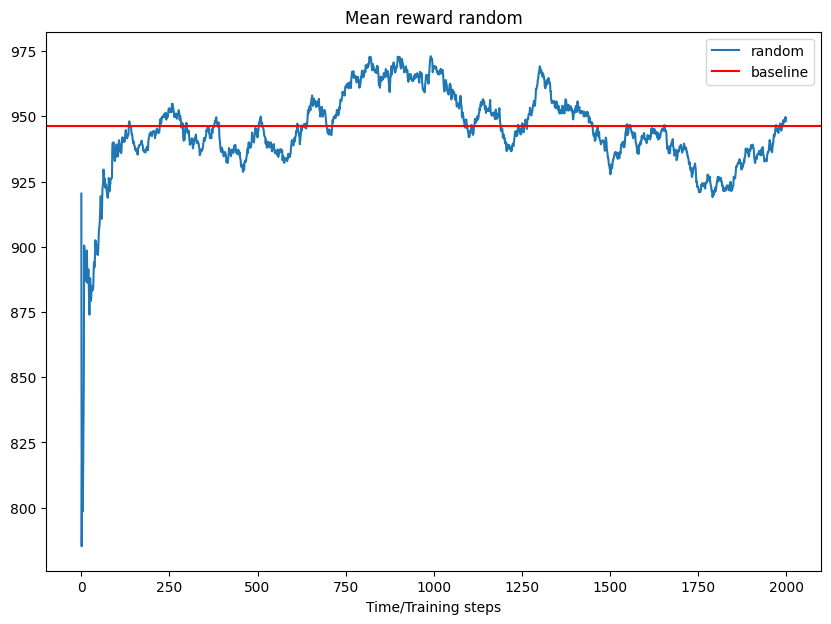

In [9]:
plot_rewards_timestamp(rewards, reward_mean_baseline=mean_reward_all_sim_random_walk, model_name=MODEL_NAME)

Usaremos el promedio obtenido del modelo aleatorio para compararlo con otros modelos

In [10]:
results_df = append_reward_stats(rewards,MODEL_NAME,time_spend=time_spend,num_episodes = NUM_EPISODES)
results_df

,model_name,n_episodes,mean_reward,std_reward,min_reward,max_reward,time_spend
0,random,2000,946.231465,159.563236,565.125547,1988.343424,32.161651


# Bandits

In [11]:
# vemos la configuración por defecto actual de bandits
print(f"Bandit's default config is:")
pprint(BANDIT_DEFAULT_CONFIG)


Bandit's default config is:
{'_disable_action_flattening': False,
 '_disable_execution_plan_api': True,
 '_disable_preprocessor_api': False,
 '_fake_gpus': False,
 '_tf_policy_handles_more_than_one_loss': False,
 'action_space': None,
 'actions_in_input_normalized': False,
 'always_attach_evaluation_results': False,
 'batch_mode': 'truncate_episodes',
 'buffer_size': -1,
 'callbacks': <class 'ray.rllib.algorithms.callbacks.DefaultCallbacks'>,
 'clip_actions': False,
 'clip_rewards': None,
 'collect_metrics_timeout': -1,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'disable_env_checking': False,
 'eager_max_retraces': 20,
 'eager_tracing': False,
 'enable_connectors': False,
 'enable_tf1_exec_eagerly': False,
 'env': None,
 'env_config': {},
 'env_task_fn': None,
 'evaluation_config': {},
 'evaluation_duration': 10,
 'evaluation_duration_unit': 'episodes',
 'evaluation_interval': None,
 'evaluation_n


Es necesario configurarla para nuestro caso de uso

In [12]:
MODEL_NAME = "banditsLinUCB"
SMOTHING_WIN = 200
NUM_EPISODES = 2000
env_bandit_config = BANDIT_DEFAULT_CONFIG

env_bandit_config.update({
    "env": REGISTER_ENV_NAME, # nombre del entorno que hemos registrado
    "env_config": env_config, # configuración del entorno
    "seed": SEED, # seed para el trainer

    "timesteps_per_iteration": 1, # genera un dict de resultados cada time step
    "metrics_num_episodes_for_smoothing": SMOTHING_WIN, # muestra los rewards suavizados con la media cada 200 episodios
})
# creamos el trainer con esta configuración
bandit_trainer = BanditLinUCBTrainer(config=env_bandit_config)
bandit_trainer

2022-09-01 18:22:49,749	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.algorithms.bandit.bandit.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.bandit.bandit.BanditLin[UCB|TS]Config(...)` instead. This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\rllib\utils\debug\deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
2022-09-01 18:22:49,753	WARNING deprecation.py:47 -- DeprecationWarning: `timesteps_per_iteration` has been deprecated. Use ``min_sample_timesteps_per_iteration` OR `min_train_timesteps_per_iteration`` instead. This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required objec

BanditLinUCB

In [13]:
#ejecutamos la simulacion
rewards,time_spend = run_simulation(bandit_trainer,agg_func="mean",num_episodes=NUM_EPISODES)

100%|██████████| 2000/2000 [00:36<00:00, 54.25it/s]


../src\visualization\visualize.py:13: RuntimeWarning: Mean of empty slice
  y = [np.nanmean(rewards[max(i - smothing_win, 0):i + 1]) for i in range(start_at, len(rewards))]


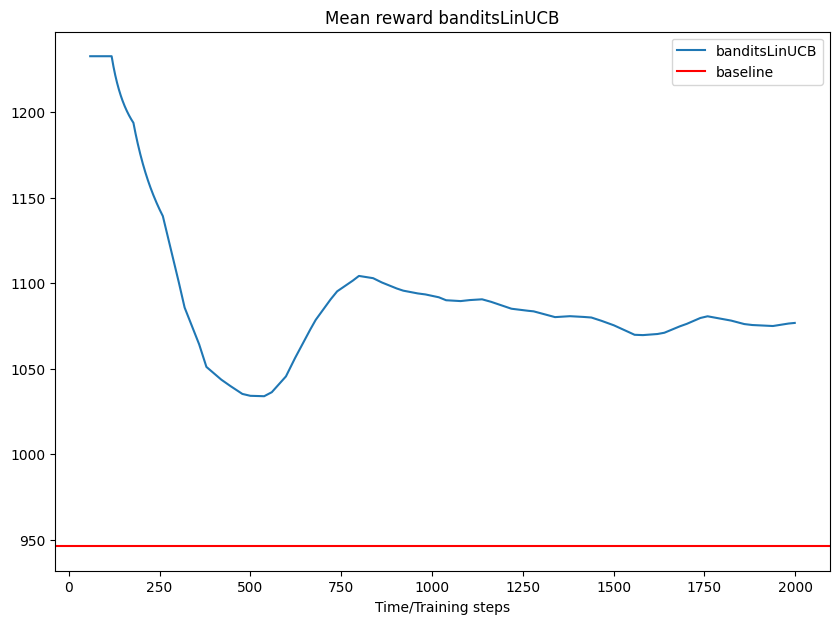

In [14]:
plot_rewards_timestamp(rewards, reward_mean_baseline=mean_reward_all_sim_random_walk, model_name=MODEL_NAME)

In [15]:
results_df = append_reward_stats(rewards,MODEL_NAME,time_spend=time_spend,df = results_df,num_episodes = NUM_EPISODES)
results_df

,model_name,n_episodes,mean_reward,std_reward,min_reward,max_reward,time_spend
0,random,2000,946.231465,159.563236,565.125547,1988.343424,32.161651
1,banditsLinUCB,2000,1082.959410,35.788409,1022.213936,1232.612939,36.872707


Evaluar cuales están siendo las recomendaciones del bandits

In [16]:
run_one_single_episode(env_lts,bandit_trainer)

action's feature value=0.797092854976654; max-choc-feature=0.797092854976654; 
action's feature value=0.9992102384567261; max-choc-feature=0.9992102384567261; 
action's feature value=0.8395598530769348; max-choc-feature=0.8395598530769348; 
action's feature value=0.7546059489250183; max-choc-feature=0.7546059489250183; 
action's feature value=0.9555328488349915; max-choc-feature=0.9555328488349915; 
action's feature value=0.8521614074707031; max-choc-feature=0.8521614074707031; 
action's feature value=0.851241409778595; max-choc-feature=0.851241409778595; 
action's feature value=0.9670387506484985; max-choc-feature=0.9670387506484985; 
action's feature value=0.9107319712638855; max-choc-feature=0.9107319712638855; 
action's feature value=0.9867180585861206; max-choc-feature=0.9867180585861206; 
action's feature value=0.9956403374671936; max-choc-feature=0.9956403374671936; 
action's feature value=0.9809534549713135; max-choc-feature=0.9809534549713135; 
action's feature value=0.9738221

# DQN
A continuación probamos un modelo DQN. Guardaremos los datos del output del mismo para luego utilizar offline RL.

In [17]:
SMOTHING_WIN = 250
MODEL_NAME = "DQN"
NUM_EPISODES = 1000
# Offline input (JSON) file:
#OUTPUT_DIR = "..\\data\\processed\\offline_rl\\longinterest_recsim"
#if not os.path.exists(OUTPUT_DIR):
#    os.makedirs(OUTPUT_DIR)

env_dqn_config = DQN_DEFAULT_CONFIG

env_dqn_config.update({
    "env": REGISTER_ENV_NAME,
    "env_config": env_config,
    "seed": SEED, # seed para el trainer

    "timesteps_per_iteration": 100, # genera un dict de resultados cada time step
    "metrics_num_episodes_for_smoothing": SMOTHING_WIN, # muestra los rewards suavizados con la media cada 200 episodios
 #   "output": OUTPUT_DIR, # añadimos esto para luego hacer offline RL
 #   "output_config": {
 #       "format": "json",  # json o parquet
 #       "store_infos" : True, # guardar la info
 #        "max_num_samples_per_file": 500_000,
 #   },
    "exploration_config": {
            "type": "SoftQ",
            "temperature": 1.0,
        },
})
# creamos el trainer con esta configuración
dqn_trainer = DQNTrainer(config=env_dqn_config)
dqn_trainer

2022-09-01 18:23:32,184	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.algorithms.dqn.dqn.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.algorithms.dqn.dqn.DQNConfig(...)` instead. This will raise an error in the future!
2022-09-01 18:23:32,186	WARNING deprecation.py:47 -- DeprecationWarning: `timesteps_per_iteration` has been deprecated. Use ``min_sample_timesteps_per_iteration` OR `min_train_timesteps_per_iteration`` instead. This will raise an error in the future!
2022-09-01 18:23:32,186	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (http

DQN

In [18]:
rewards,time_spend = run_simulation(dqn_trainer,agg_func="mean",num_episodes =NUM_EPISODES)

  0%|          | 0/1000 [00:00<?, ?it/s]2022-09-01 18:23:33,635	WARNING deprecation.py:47 -- DeprecationWarning: `ReplayBuffer.add_batch()` has been deprecated. Use `ReplayBuffer.add()` instead. This will raise an error in the future!
2022-09-01 18:23:33,645	WARNING multi_agent_prioritized_replay_buffer.py:220 -- Adding batches with column `weights` to this buffer while providing weights as a call argument to the add method results in the column being overwritten.
100%|██████████| 1000/1000 [17:11<00:00,  1.03s/it]


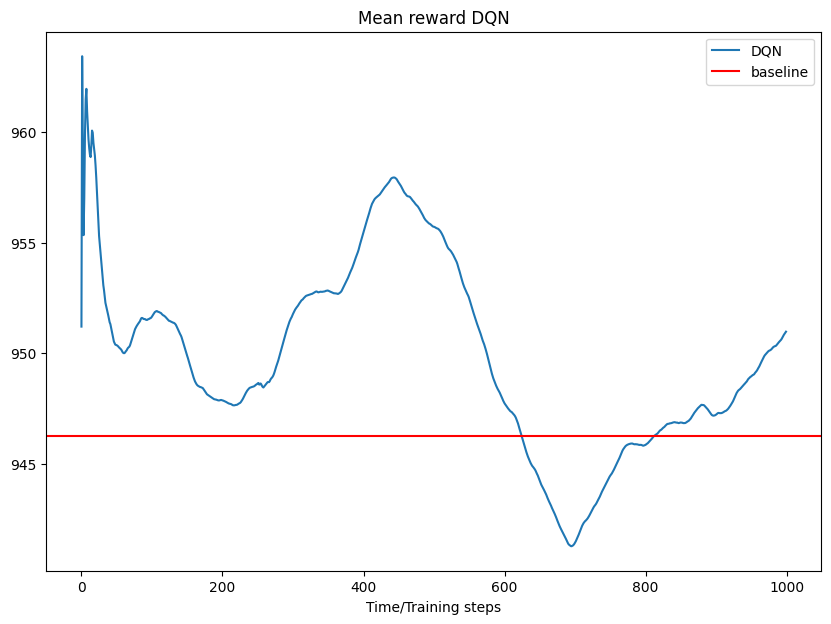

In [19]:
plot_rewards_timestamp(rewards=rewards,reward_mean_baseline=mean_reward_all_sim_random_walk, model_name=MODEL_NAME,smothing_win=SMOTHING_WIN)

In [20]:
results_df = append_reward_stats(rewards,MODEL_NAME,time_spend=time_spend,df = results_df,num_episodes = NUM_EPISODES)
results_df

,model_name,n_episodes,mean_reward,std_reward,min_reward,max_reward,time_spend
0,random,2000,946.231465,159.563236,565.125547,1988.343424,32.161651
1,banditsLinUCB,2000,1082.959410,35.788409,1022.213936,1232.612939,36.872707
2,DQN,1000,949.918250,10.339271,925.450798,976.598211,1031.077120


# SlateQ
A continuación ejecutamos el modelo SlateQ. Primero vemos todos los parámetros configurables del mismo y luego modificamos aquellos que nos interesa para nuestro modelo.

Ejecutamos el modelo de SlateQ

In [21]:
SMOTHING_WIN = 200
MODEL_NAME = "slateQ"
NUM_EPISODES = 150

slateq_config = SLATEQ_DEFAULT_CONFIG
slate_env_config = {
        "num_candidates": NUM_CANDIDATES, # obtenemos un caso MultiDiscrete([20,20]) debido a que tenemos 2 slate_size y 20 posibles documentos
        "slate_size": SLATE_SIZE,
        "resample_documents": True,
        "wrap_for_bandits": False,  # Necesario para que el agente sea un slateq
        "convert_to_discrete_action_space": False,  # En slateq tenemos un espacio múltiple
    }
slateq_config_update = {
    "env": REGISTER_ENV_NAME,
    "env_config": slate_env_config,
    # Setup exploratory behavior: Implemented as "epsilon greedy" strategy:
    # Act randomly `e` percent of the time; `e` gets reduced from 1.0 to almost 0.0 over
    # the course of `epsilon_timesteps`.
    "exploration_config": {
      #  "type": "SlateEpsilonGreedy", #SlateSoftQ or SlateEpsilonGreedy
        "warmup_timesteps": 20000,  # valor por defecto
        #"epsilon_timesteps": 40000 #tune.grid_search([40000, 2000, 3000]),  # default: 250000
    },
    "learning_starts": 20000,  # valor por defecto
    "target_network_update_freq": 3200,
    #'framework': 'torch', #necesario para slateSoftQ

    # Report rewards as smoothed mean over this many episodes.
    "metrics_num_episodes_for_smoothing": SMOTHING_WIN,
    
    
   
}

SLATEQ_DEFAULT_CONFIG.update(slateq_config_update)

# Instantiate the Trainer object using the exact same config as in our Bandit experiment above.
slateq_trainer = SlateQTrainer(config=slateq_config_update)
slateq_trainer

2022-09-01 18:40:44,972	WARNING deprecation.py:47 -- DeprecationWarning: `config['learning_starts']` has been deprecated. config['replay_buffer_config']['learning_starts'] This will raise an error in the future!
2022-09-01 18:40:44,973	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!


Instructions for updating:
Use fn_output_signature instead


C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
2022-09-01 18:40:58,651	INFO trainable.py:160 -- Trainable.setup took 13.680 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-09-01 18:40:58,653	WARNING util.py:65 -- Install gputil for GPU system monitoring.


SlateQ

In [22]:
rewards,time_spend = run_simulation(slateq_trainer,agg_func="mean",num_episodes =NUM_EPISODES)

100%|██████████| 150/150 [41:15<00:00, 16.50s/it]


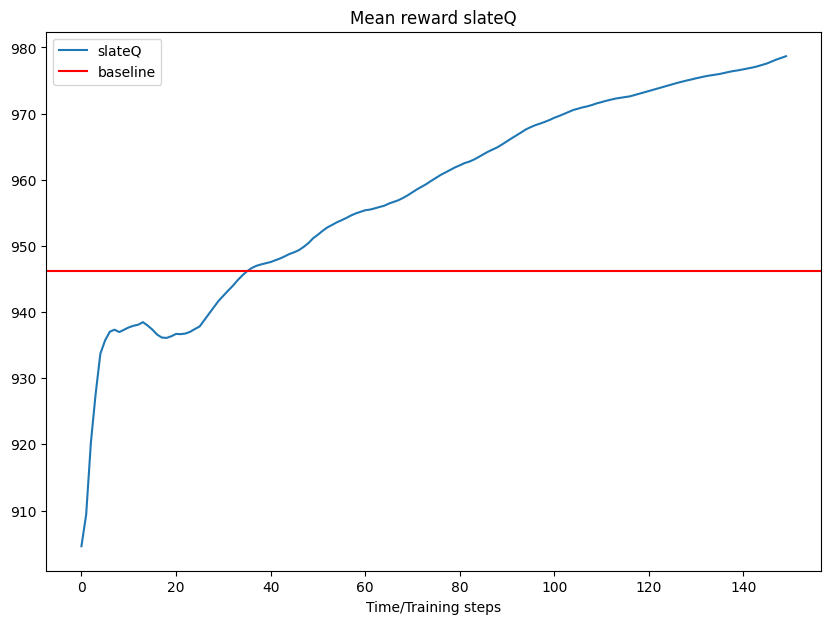

In [23]:
plot_rewards_timestamp(rewards=rewards,reward_mean_baseline=mean_reward_all_sim_random_walk, model_name=MODEL_NAME,smothing_win=SMOTHING_WIN)

In [ ]:
env_lts_slate = LongTermSatisfactionRecSimEnv(slate_env_config)

run_one_single_episode(env_lts_slate,slateq_trainer,model="slateq")

In [24]:
results_df = append_reward_stats(rewards,MODEL_NAME,time_spend=time_spend,df = results_df,num_episodes = NUM_EPISODES)
results_df

,model_name,n_episodes,mean_reward,std_reward,min_reward,max_reward,time_spend
0,random,2000,946.231465,159.563236,565.125547,1988.343424,32.161651
1,banditsLinUCB,2000,1082.959410,35.788409,1022.213936,1232.612939,36.872707
2,DQN,1000,949.918250,10.339271,925.450798,976.598211,1031.077120
3,slateQ,150,978.666729,23.769128,904.608119,1021.618865,2475.318015


In [25]:
results_df["env"] = "lts_default"
results_df_lts = results_df.copy()


# Entorno modificado
A continuación, realizamos los mismos modelos con el entorno modificado al que hemos aumentado la satisfacción.

100%|██████████| 2000/2000 [01:04<00:00, 30.84it/s]


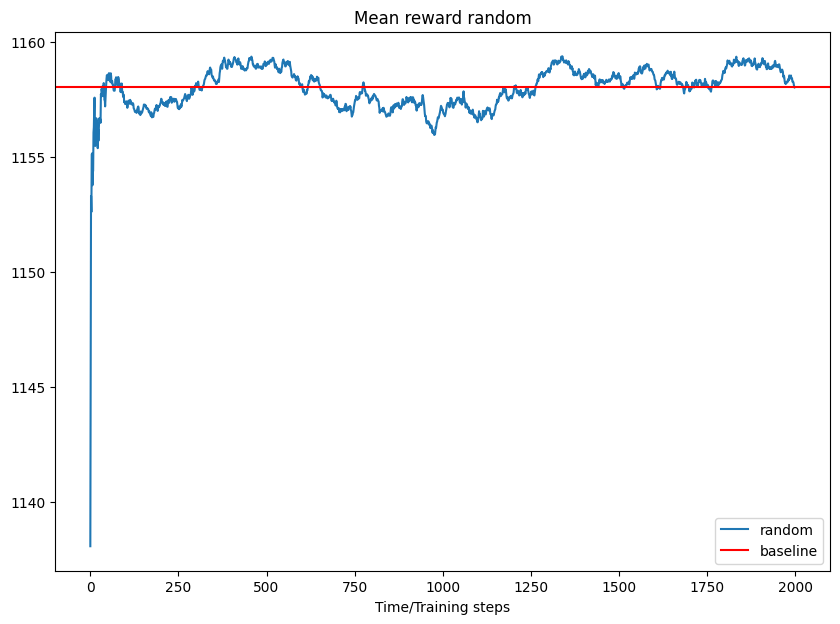

In [26]:
# BASELINE: Random Walk
NUM_EPISODES = 2000
MODEL_NAME = "random"
# simulacion de una serie de episodios
rewards,time_spend = run_simulation(env_lts_mod, func= run_random_walk_episode, num_episodes=NUM_EPISODES)
mean_reward_all_sim_random_walk = np.mean(rewards)
results_df = append_reward_stats(rewards,MODEL_NAME,time_spend=time_spend,num_episodes = NUM_EPISODES)
plot_rewards_timestamp(rewards, reward_mean_baseline=mean_reward_all_sim_random_walk, model_name=MODEL_NAME)

C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\rllib\utils\debug\deterministic.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) >= LooseVersion("1.8.0"):
2022-09-01 20:09:30,880	WARNING deprecation.py:47 -- DeprecationWarning: `timesteps_per_iteration` has been deprecated. Use ``min_sample_timesteps_per_iteration` OR `min_train_timesteps_per_iteration`` instead. This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-01 20:09:30,899	WARNING util.py:65 -- Ins

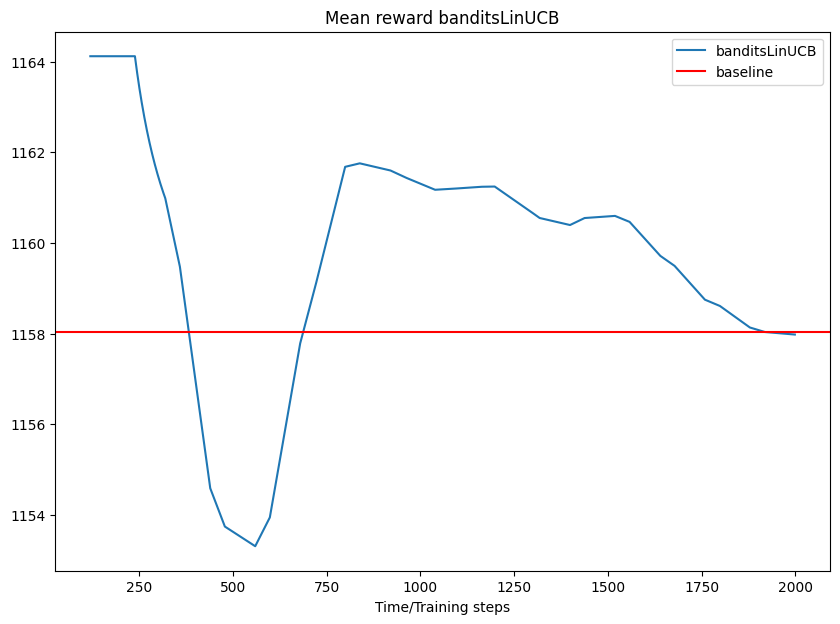

In [27]:
MODEL_NAME = "banditsLinUCB"
SMOTHING_WIN = 200
NUM_EPISODES = 2000
env_bandit_config.update({
    "env": REGISTER_ENV_NAME_MOD, # nombre del entorno que hemos registrado
  })
# creamos el trainer con esta configuración
bandit_trainer = BanditLinUCBTrainer(config=env_bandit_config)
rewards,time_spend = run_simulation(bandit_trainer,agg_func="mean",num_episodes=NUM_EPISODES)
results_df = append_reward_stats(rewards,MODEL_NAME,time_spend=time_spend,df = results_df,num_episodes = NUM_EPISODES)
plot_rewards_timestamp(rewards, reward_mean_baseline=mean_reward_all_sim_random_walk, model_name=MODEL_NAME)


2022-09-01 20:10:10,214	WARNING deprecation.py:47 -- DeprecationWarning: `timesteps_per_iteration` has been deprecated. Use ``min_sample_timesteps_per_iteration` OR `min_train_timesteps_per_iteration`` instead. This will raise an error in the future!
2022-09-01 20:10:10,215	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-01 20:10:11,715	WARNING util.py:65 -- Install gputil for GPU system monitoring.
10

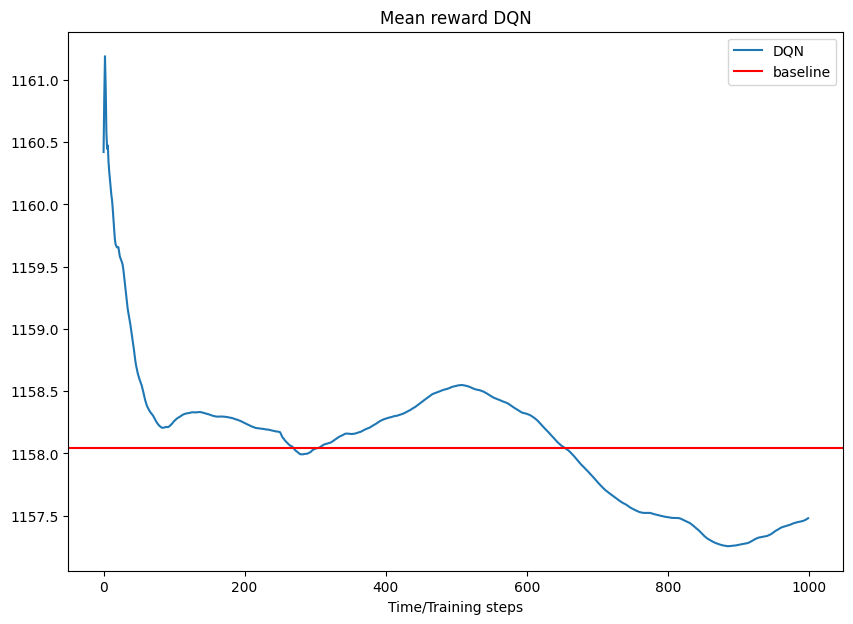

In [28]:
SMOTHING_WIN = 250
MODEL_NAME = "DQN"
NUM_EPISODES = 1000
env_dqn_config.update({
    "env": REGISTER_ENV_NAME_MOD,})
dqn_trainer = DQNTrainer(config=env_dqn_config)
rewards,time_spend = run_simulation(dqn_trainer,agg_func="mean",num_episodes =NUM_EPISODES)

results_df = append_reward_stats(rewards,MODEL_NAME,time_spend=time_spend,df = results_df,num_episodes = NUM_EPISODES)
plot_rewards_timestamp(rewards=rewards,reward_mean_baseline=mean_reward_all_sim_random_walk, model_name=MODEL_NAME,smothing_win=SMOTHING_WIN)

2022-09-01 20:27:31,956	WARNING deprecation.py:47 -- DeprecationWarning: `config['learning_starts']` has been deprecated. config['replay_buffer_config']['learning_starts'] This will raise an error in the future!
2022-09-01 20:27:31,957	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
C:\Users\Paul\AppData\Roaming\Python\Python39\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-01 20:27:43,881	INFO trainable.py:160 -- Trainable.setup took 11.925 seconds. If your trainable is slow to initialize, co

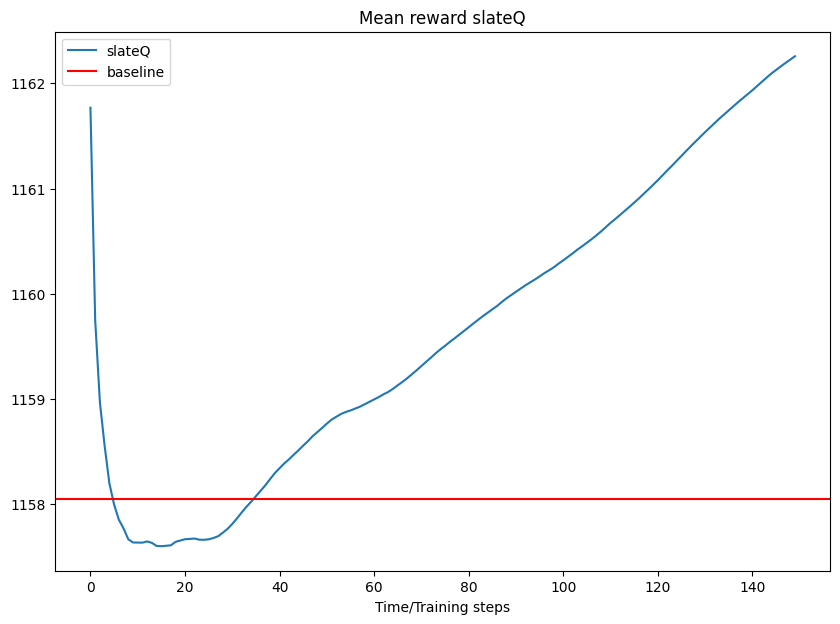

In [29]:
MODEL_NAME = "slateQ"
NUM_EPISODES = 150
SMOTHING_WIN = 200
slateq_config_update.update({
    "env": REGISTER_ENV_NAME_MOD,})
slateq_trainer = SlateQTrainer(config=slateq_config_update)
rewards,time_spend = run_simulation(slateq_trainer,agg_func="mean",num_episodes =NUM_EPISODES)
results_df = append_reward_stats(rewards,MODEL_NAME,time_spend=time_spend,df = results_df,num_episodes = NUM_EPISODES)
plot_rewards_timestamp(rewards=rewards,reward_mean_baseline=mean_reward_all_sim_random_walk, model_name=MODEL_NAME,smothing_win=SMOTHING_WIN)

In [37]:
results_df

,model_name,n_episodes,mean_reward,std_reward,min_reward,max_reward,time_spend,env
0,random,2000,1158.046473,11.403558,1120.505639,1195.183100,64.851487,lts_default
1,banditsLinUCB,2000,1159.355017,2.904273,1151.988803,1164.120444,39.070816,lts_default
2,DQN,1000,1157.937847,0.652343,1156.633428,1161.832116,1040.027555,lts_default
3,slateQ,150,1162.256963,3.314112,1156.780417,1167.749938,2467.855278,lts_default


In [38]:
results_df["env"] = "lts_mod"

In [39]:
results_df_ltsm = results_df.copy()

In [43]:
pd.concat([results_df_ltsm,results_df_lts]).to_csv("../models/online_rl/lts/results_ltsm_lts.csv")

2022-09-02 20:46:18,734	WARNING worker.py:1829 -- The node with node id: 0720f1dcd9f51ec264c2477ce32cf8acaba452552731bf64a0558029 and address: 127.0.0.1 and node name: 127.0.0.1 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a 	(1) raylet crashes unexpectedly (OOM, preempted node, etc.) 
	(2) raylet has lagging heartbeats due to slow network or busy workload.
(pid=) [2022-09-02 21:05:34,270 C 7092 21840] (raylet.exe) node_manager.cc:988: [Timeout] Exiting because this node manager has mistakenly been marked as dead by the GCS: GCS didn't receive heartbeats from this node for 30000 ms. This is likely because the machine or raylet has become overloaded.
(pid=) *** StackTrace Information ***
(pid=) unknown
(pid=) unknown
(pid=) unknown
(pid=) unknown
(pid=) unknown
(pid=) unknown
(pid=) unknown
(pid=) unknown
(pid=) unknown
(pid=) unknown
(pid=) unknown
(pid=) unknown
(pid=) unknown
(pid=) BaseThreadInitThunk
(pid=) RtlUserThreadStar